In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import openpyxl

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from scipy import stats
import shap

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.float_format', '{:.3f}'.format)

---
# 1. Importowanie danych



In [2]:
df_default = pd.read_excel('Case_study.xlsx', sheet_name='Default_data')
df_gdp = pd.read_excel('Case_study.xlsx', sheet_name='GDP_data')

In [3]:
df_gdp.head()

,Year,GDP
0,1999,242307.600
1,2000,256376.400
2,2001,264334.900
3,2002,273255.900
4,2003,281200.200


In [4]:
df_default.head()

,ID,Reporting_date,DPD,TtM,In_default
0,1,2003,0,0.939,0
1,2,2013,18,0.056,0
2,3,2004,0,0.983,0
3,4,2003,0,0.565,0
4,5,2013,0,0.948,0


### Default_data

- `ID` – Unikalny identyfikator ekspozycji.  
- `Reporting_date` – Rok obserwacji.  
- `DPD` – "Dni opóźnienia" dla ekspozycji, tj. wskaźnik, jak bardzo klient zalega z harmonogramem spłaty kredytu.  
- `TtM` – Względny czas do zapadalności, tj. stosunek pozostałego okresu zapadalności do pierwotnego okresu zapadalności ekspozycji.  
- `In_default` – Wskaźnik, czy dany ID wszedł w stan niewypłacalności w ciągu 12 miesięcy od daty raportowania.  
    - `1`: Ekspozycja weszła w stan niewypłacalności w ciągu następnych 12 miesięcy (stała się "zła").  
    - `0`: Ekspozycja nie weszła w stan niewypłacalności.


### GDP_data

- `Year` – Rok związany z daną wartością PKB.  
- `GDP` – Produkt Krajowy Brutto dla danego kraju.


---

# 2. Eksploracja i zrozumienie danych

In [5]:
print(df_default.shape)
print(df_gdp.shape)
print(df_default.duplicated().sum())
print(df_gdp.duplicated().sum())
print(df_default.isnull().sum())
print(df_gdp.isnull().sum())

(20000, 5)
(21, 2)
0
0
ID                0
Reporting_date    0
DPD               0
TtM               0
In_default        0
dtype: int64
Year    0
GDP     0
dtype: int64


In [6]:
df_gdp_filtered = df_gdp.copy()
df_gdp_filtered['Yearly_Growth'] = df_gdp_filtered['GDP'].pct_change() * 100
df_gdp_filtered.query('Year >= 2000', inplace=True)

df_gdp_filtered.head()

,Year,GDP,Yearly_Growth
1,2000,256376.400,5.806
2,2001,264334.900,3.104
3,2002,273255.900,3.375
4,2003,281200.200,2.907
5,2004,296819.700,5.555


### Dlaczego wskaźniki wzrostu są lepsze od wartości nominalnych

Wskaźniki wzrostu są często preferowane w analizie danych i badaniach ekonomicznych z następujących powodów:

1. **Standaryzacja w różnych skalach**:
    - Wskaźniki wzrostu dostarczają względnej miary zmiany, co ułatwia porównywanie jednostek o różnych rozmiarach lub skalach. Na przykład porównywanie wskaźników wzrostu PKB między krajami jest bardziej znaczące niż porównywanie ich nominalnych wartości PKB, ponieważ kraje różnią się znacznie pod względem wielkości i produkcji gospodarczej.

2. **Skupienie na trendach**:
    - Wskaźniki wzrostu podkreślają trendy i wzorce w czasie, pozwalając zrozumieć kierunek i tempo zmian. Jest to szczególnie przydatne do identyfikacji okresów ekspansji lub recesji gospodarczej.

3. **Eliminacja uprzedzeń związanych z rozmiarem**:
    - Wartości nominalne mogą być mylące przy porównywaniu jednostek o znacznie różnych rozmiarach. Wskaźniki wzrostu normalizują dane, eliminując uprzedzenia wprowadzone przez różnice w rozmiarze absolutnym.

4. **Wgląd w wydajność**:
    - Wskaźniki wzrostu są lepszym wskaźnikiem wydajności i efektywności. Na przykład mała firma z wysokim wskaźnikiem wzrostu może radzić sobie lepiej niż duża firma z stagnacją wzrostu, mimo że ta druga ma wyższe nominalne przychody.

5. **Korekta inflacji**:
    - W kontekście ekonomicznym wartości nominalne są często wpływane przez inflację. Wskaźniki wzrostu, szczególnie realne wskaźniki wzrostu, uwzględniają inflację i dostarczają jaśniejszego obrazu rzeczywistego postępu gospodarczego.


In [7]:
df_merged = df_default.merge(df_gdp_filtered, left_on='Reporting_date', right_on='Year', how='left')
df_merged.drop(columns=['Year', 'GDP'], inplace=True)
df_merged['Reporting_date'] = df_merged['Reporting_date'].astype('category')
df_merged.drop('ID', axis=1, inplace=True)

df_merged.head()

,Reporting_date,DPD,TtM,In_default,Yearly_Growth
0,2003,0,0.939,0,2.907
1,2013,18,0.056,0,1.736
2,2004,0,0.983,0,5.555
3,2003,0,0.565,0,2.907
4,2013,0,0.948,0,1.736


In [8]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Reporting_date  20000 non-null  category
 1   DPD             20000 non-null  int64   
 2   TtM             20000 non-null  float64 
 3   In_default      20000 non-null  int64   
 4   Yearly_Growth   20000 non-null  float64 
dtypes: category(1), float64(2), int64(2)
memory usage: 645.4 KB


In [9]:
print('Statystyki opisowe dla kolumn numerycznych:')
print('---------------------------')
print(df_merged.describe(include =['number']))

Statystyki opisowe dla kolumn numerycznych:
---------------------------
            DPD       TtM  In_default  Yearly_Growth
count 20000.000 20000.000   20000.000      20000.000
mean      7.631     1.725       0.038          3.427
std      71.290   173.350       0.191          1.575
min   -6300.000     0.000       0.000         -1.498
25%       0.000     0.251       0.000          2.907
50%       0.000     0.495       0.000          3.375
75%       9.000     0.748       0.000          4.811
max    7600.000 24515.817       1.000          5.806


In [10]:
print('Statystyki opisowe dla kolumn kategorycznych:')
print('------------------------------------------------')
print(df_merged.describe(include=['object', 'category']))

Statystyki opisowe dla kolumn kategorycznych:
------------------------------------------------
        Reporting_date
count            20000
unique              20
top               2004
freq              1044


In [11]:
df_merged.shape

(20000, 5)

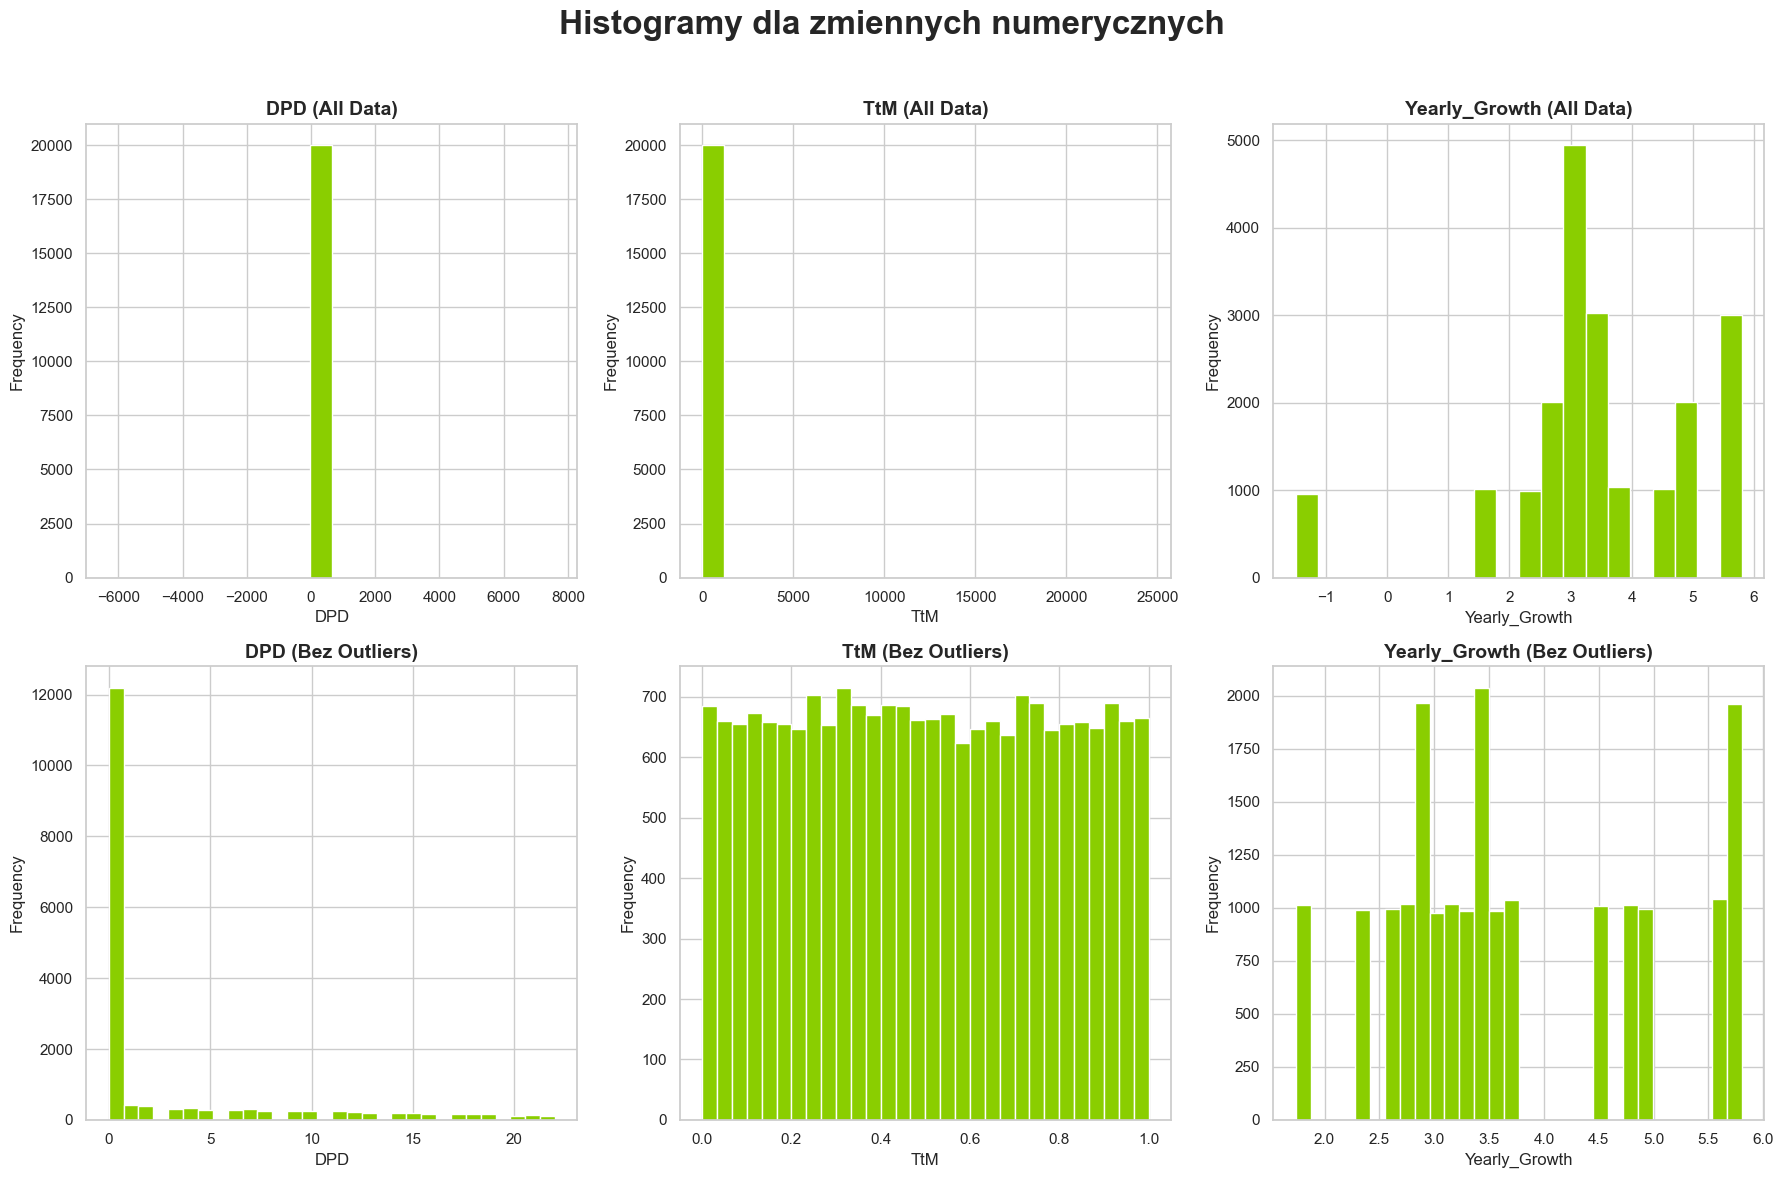

In [12]:
numerical_columns = df_merged.select_dtypes(include=[np.number]).drop(columns= 'In_default').columns.tolist()

sns.set_theme(style="whitegrid")
palette = sns.color_palette("pastel")

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle("Histogramy dla zmiennych numerycznych", fontsize=24, fontweight='bold')

for i, column in enumerate(numerical_columns):
    axes[0, i].hist(df_merged[column], bins=20, color='#8ACE00')
    axes[0, i].set_title(f"{column} (All Data)", fontsize=14, fontweight='bold')
    axes[0, i].set_xlabel(column, fontsize=12)
    axes[0, i].set_ylabel("Frequency", fontsize=12)
    
    data = df_merged[column].copy()
    q1, q3 = data.quantile(0.25), data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]
    
    axes[1, i].hist(filtered_data, bins=30, color='#8ACE00')
    axes[1, i].set_title(f"{column} (Bez Outliers)", fontsize=14, fontweight='bold')
    axes[1, i].set_xlabel(column, fontsize=12)
    axes[1, i].set_ylabel("Frequency", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

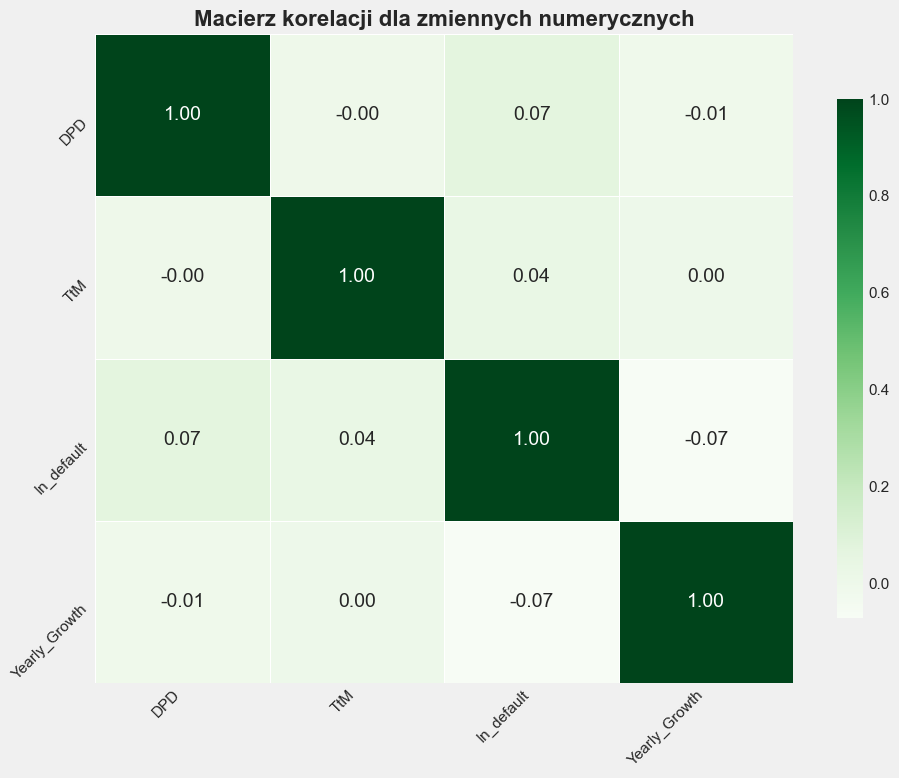

In [13]:
plt.style.use('fivethirtyeight')

correlation = df_merged.select_dtypes(include=['number']).corr()

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(
    correlation,
    annot=True,
    cmap='Greens',
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, va='top')
plt.title('Macierz korelacji dla zmiennych numerycznych', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [14]:
df_numeric = df_merged.select_dtypes(include=['number']).copy()

correlation_results = {}
for col in df_numeric.columns:
    if col != "In_default":  
        corr, p_value = stats.pearsonr(df_numeric[col], df_numeric["In_default"])
        correlation_results[col] = {"Pearson_corr": corr, "p_value": p_value}

# Tworzymy DataFrame z wynikami
correlation_df = pd.DataFrame.from_dict(correlation_results, orient="index")
print(correlation_df)

               Pearson_corr  p_value
DPD                   0.068    0.000
TtM                   0.036    0.000
Yearly_Growth        -0.072    0.000


 - **Korelacje są bardzo słabe, więc wpływ tych zmiennych na siebie nawzajem jest marginalny.**

 - **Statystycznie istotne, ale praktycznie nie mają wielkiego znaczenia, biorąc pod uwagę bardzo małe wartości korelacji**

In [15]:
default_group = df_merged[df_merged["In_default"] == 1]
non_default_group = df_merged[df_merged["In_default"] == 0]


t_test_results = {}


numeric_cols = df_merged.select_dtypes(include=[float, int]).columns

for col in numeric_cols:
    if col != "In_default":
        t_stat, p_value = stats.ttest_ind(default_group[col].dropna(), 
                                          non_default_group[col].dropna(), 
                                          equal_var=False) 
        t_test_results[col] = {"t_statistic": t_stat, "p_value": p_value}


t_test_df = pd.DataFrame.from_dict(t_test_results, orient="index")
print(t_test_df)


               t_statistic  p_value
DPD                  3.006    0.003
TtM                  1.000    0.318
Yearly_Growth       -8.564    0.000


---

# 3. Przygotowanie danych

 ## 3.1 Diagnozowanie wartości odstających

In [16]:
df_merged.sort_values(by='DPD', ascending=False)

,Reporting_date,DPD,TtM,In_default,Yearly_Growth
11341,2011,7600,0.725,0,3.532
11739,2014,89,0.821,1,2.577
13497,2011,89,0.676,1,3.532
12743,2019,89,0.808,1,2.949
19857,2000,89,0.653,1,5.806
...,...,...,...,...,...
8322,2005,0,0.334,0,4.453
8323,2004,0,0.145,0,5.555
8324,2016,0,0.323,0,3.247
10000,2009,0,0.559,0,-1.498


In [17]:
df_merged.sort_values(by='TtM', ascending=False)

,Reporting_date,DPD,TtM,In_default,Yearly_Growth
7642,2011,0,24515.817,1,3.532
811,2007,12,1.000,0,5.680
1477,2010,4,1.000,0,4.811
15330,2017,0,1.000,0,3.655
12916,2012,0,1.000,0,2.715
...,...,...,...,...,...
10351,2013,18,0.000,0,1.736
14294,2005,5,0.000,0,4.453
19198,2002,0,0.000,0,3.375
11924,2017,0,0.000,0,3.655


In [18]:
print(df_merged.query('DPD > 90 or DPD < 0 or TtM > 1 or TtM < 0'))
print()
print('------------------------------------------------')
print(df_merged.shape)
df_merged = df_merged.query('not (DPD > 90 or DPD < 0 or TtM > 1 or TtM < 0)')
print(df_merged.shape)


      Reporting_date   DPD       TtM  In_default  Yearly_Growth
7642            2011     0 24515.817           1          3.532
11341           2011  7600     0.725           0          3.532
17320           2000 -6300     0.990           1          5.806

------------------------------------------------
(20000, 5)
(19997, 5)


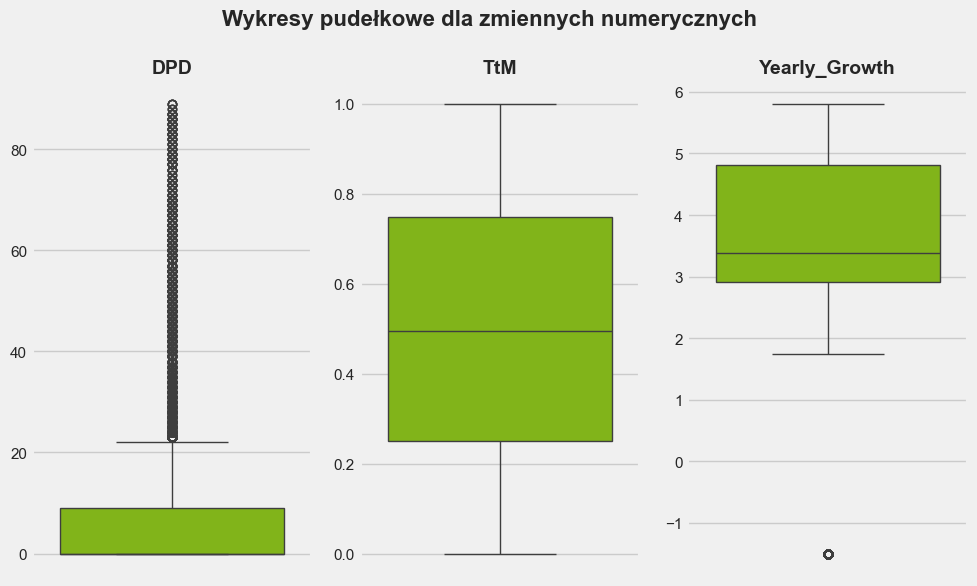

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
fig.suptitle("Wykresy pudełkowe dla zmiennych numerycznych", fontsize=16, fontweight='bold')

for i, column in enumerate(numerical_columns):
    sns.boxplot(data=df_merged, y=column, color='#8ACE00', ax=axes[i])
    axes[i].set_title(column, fontsize=14, fontweight='bold')
    axes[i].set_ylabel(None)
    

plt.tight_layout()
plt.show()


### 📌 W przypadku zmiennej DPD, wartości uznane przez boxplot za outliery (np. >30 dni) nie są błędami, lecz reprezentują najbardziej ryzykownych klientów.

## 3.2 Binowanie zmiennych

In [20]:
def dpd_bucket(dpd):
    if dpd == 0:
        return '0_DPD'
    elif 1 <= dpd <= 30:
        return '1-30_DPD'
    elif 31 <= dpd <= 60:
        return '31-60_DPD'
    elif 61 <= dpd <= 90:
        return '61-90_DPD'
   

df_merged['DPD_Bucket'] = df_merged['DPD'].apply(dpd_bucket)

avg_default_rate_year = df_merged.groupby('Reporting_date')['In_default'].mean() * 100
avg_default_rate_dpd = df_merged.groupby('DPD_Bucket')['In_default'].mean() * 100

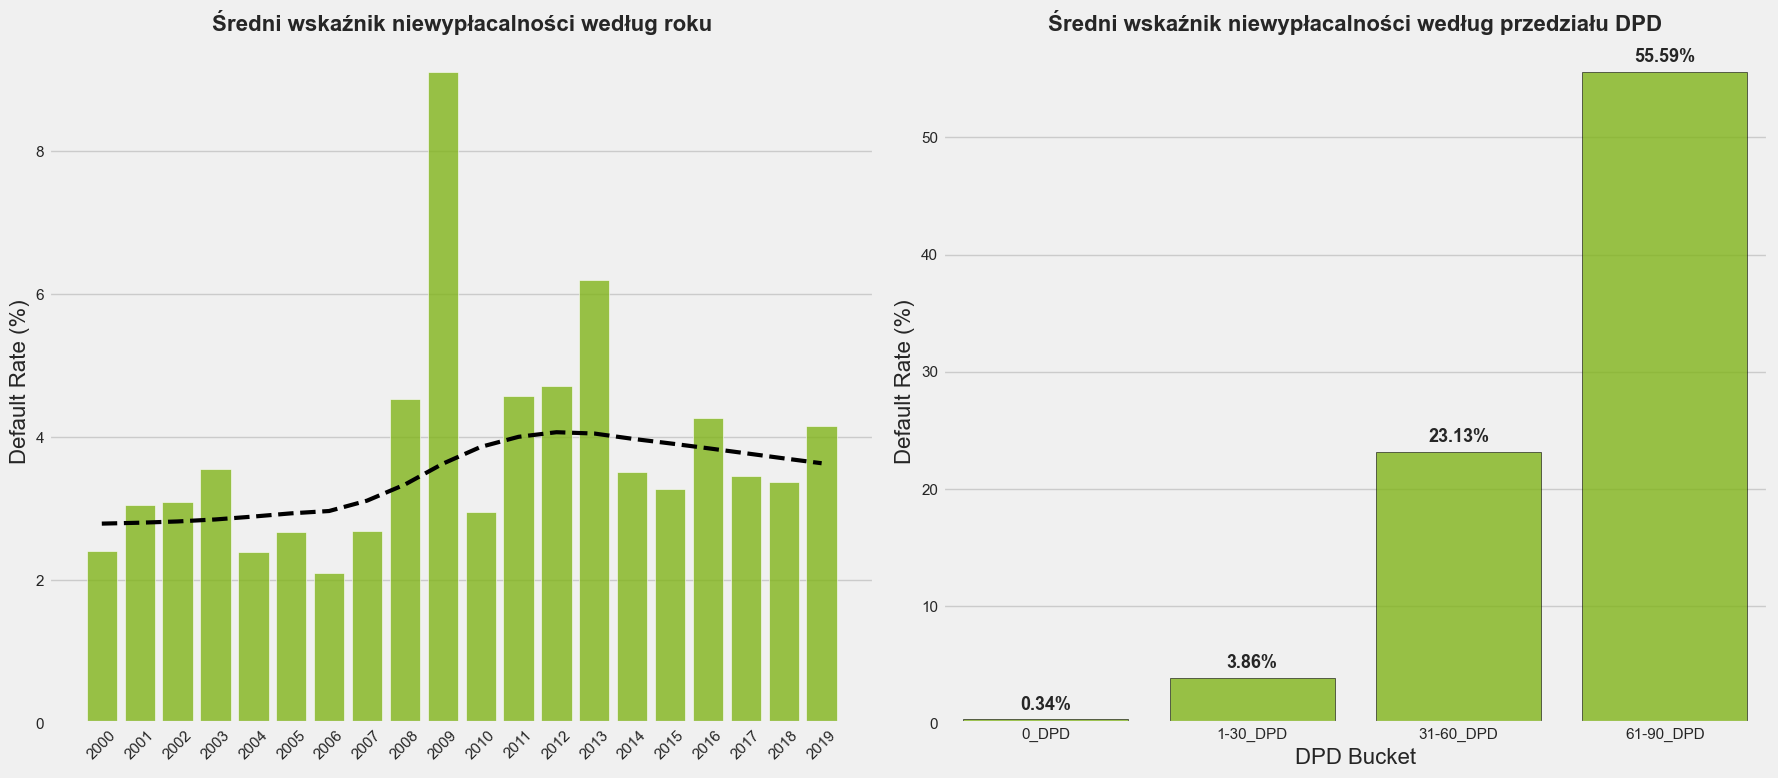

In [21]:
plt.style.use('fivethirtyeight')
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.barplot(
    x=avg_default_rate_year.index,
    y=avg_default_rate_year.values,
    ax=axes[0],
    color="#8ACE00", 
    edgecolor='white',  
    alpha=0.8
)

sns.regplot(
    x=np.arange(len(avg_default_rate_year)),
    y=avg_default_rate_year.values,
    ax=axes[0],
    scatter=False,
    color='black',
    line_kws={"linewidth": 3, "linestyle": "--"},
    lowess=True 
)

axes[0].set_title('Średni wskaźnik niewypłacalności według roku', fontsize=16, fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('Default Rate (%)', fontsize=16)
axes[0].tick_params(axis='x', rotation=45)

dpd_order = ['0_DPD', '1-30_DPD', '31-60_DPD', '61-90_DPD']
sns.barplot(
    x=avg_default_rate_dpd.index,
    y=avg_default_rate_dpd.values,
    ax=axes[1],
    order=dpd_order,
    color = '#8ACE00',
    edgecolor='black',
    alpha=0.8
)

for i, value in enumerate(avg_default_rate_dpd.values):
    axes[1].text(
        i,
        value + 0.5,
        f'{value:.2f}%',
        ha='center',
        va='bottom',
        fontsize=13,
        fontweight='bold'
    )

axes[1].set_title('Średni wskaźnik niewypłacalności według przedziału DPD', fontsize=16, fontweight='bold')
axes[1].set_xlabel('DPD Bucket', fontsize=16)
axes[1].set_ylabel('Default Rate (%)', fontsize=16)

plt.tight_layout()
plt.show()

In [22]:

def ttm_bucket(ttm):
    if ttm <= 0.25:
        return "Krótkoterminowy" 
    elif ttm <= 0.75:
        return "Średnioterminowy"  
    else:
        return "Długoterminowy"  

df_merged["TtM_bucket"] = df_merged["TtM"].apply(ttm_bucket)
avg_default_rate_ttm = df_merged.groupby('TtM_bucket')['In_default'].mean().sort_values() * 100
df_merged['TtM_bucket'].describe()


count                19997
unique                   3
top       Średnioterminowy
freq                 10073
Name: TtM_bucket, dtype: object

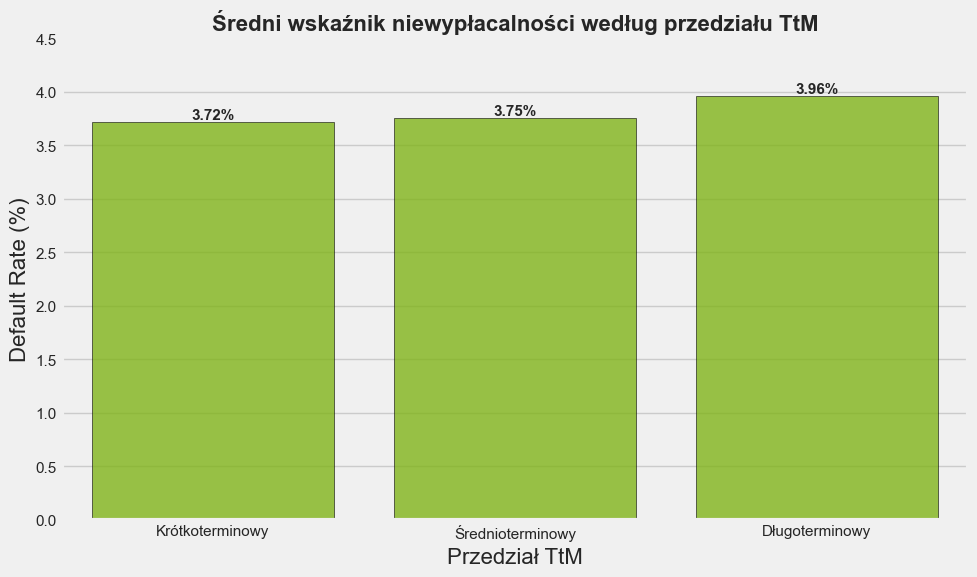

In [23]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(10, 6))

ttm_order = ['Krótkoterminowy', 'Średnioterminowy', 'Długoterminowy']
ax = sns.barplot(
    x=avg_default_rate_ttm.index,
    y=avg_default_rate_ttm.values,
    order=ttm_order,
    color="#8ACE00",
    edgecolor='black',
    alpha=0.8
)

for i, value in enumerate(avg_default_rate_ttm.values):
    ax.text(
        i, 
        value, 
        f'{value:.2f}%', 
        ha='center', 
        va='bottom', 
        fontsize=11, 
        fontweight='bold'
    )

plt.title('Średni wskaźnik niewypłacalności według przedziału TtM', fontsize=16, fontweight='bold')
plt.xlabel('Przedział TtM', fontsize=16)
plt.ylabel('Default Rate (%)', fontsize=16)
plt.ylim(0, 4.5)

plt.tight_layout()
plt.show()

## 3.3 Kodowanie danych kategorycznych

In [24]:
df_merged['Reporting_date'] = df_merged['Reporting_date'].astype('int64')

df_encoded = pd.get_dummies(df_merged, columns=['DPD_Bucket', 'TtM_bucket'], drop_first=True).copy()

df_encoded.head()

,Reporting_date,DPD,TtM,In_default,Yearly_Growth,DPD_Bucket_1-30_DPD,DPD_Bucket_31-60_DPD,DPD_Bucket_61-90_DPD,TtM_bucket_Krótkoterminowy,TtM_bucket_Średnioterminowy
0,2003,0,0.939,0,2.907,False,False,False,False,False
1,2013,18,0.056,0,1.736,True,False,False,True,False
2,2004,0,0.983,0,5.555,False,False,False,False,False
3,2003,0,0.565,0,2.907,False,False,False,False,True
4,2013,0,0.948,0,1.736,False,False,False,False,False


---
# 4. Feature engineering

In [25]:
df_encoded["dpd_nasilenie"] = df_encoded["DPD"] * (1 - df_encoded["TtM"])


📦 Zmienna: dpd_nasilenie

Zmienna `dpd_nasilenie` została stworzona jako interakcja pomiędzy zmiennymi `DPD` (dni opóźnienia) oraz `TtM` (czas do zapadalności). Wyraża ona nasilenie opóźnienia w spłacie kredytu, uwzględniając jednocześnie, jak blisko jest do końca okresu zapadalności.

📊 **Cel**:
- Zmienna ta pozwala lepiej zrozumieć ryzyko związane z opóźnieniami w spłacie kredytu, uwzględniając kontekst czasowy.

In [26]:
df_encoded['is_crisis'] = ((df_encoded['Reporting_date'] >= 2008) & (df_encoded['Reporting_date'] <= 2010)).astype(int)


 📦 Zmienna: is_crisis

Zmienna `is_crisis` wskazuje, czy dany rok raportowania (`Reporting_date`) przypada na okres globalnego kryzysu finansowego (2008-2010).

📊 **Cel**:
Dodanie tej zmiennej pozwala uwzględnić wpływ globalnego kryzysu finansowego na wskaźnik niewypłacalności klientów.


---
# 5. Modelowanie  

## 5.1 Podział danych

In [27]:
df_processed = df_encoded.copy()

X = df_processed.drop('In_default', axis=1)
y = df_processed['In_default']

columns_to_drop = ['Reporting_date']
X = X.drop(columns_to_drop, axis=1, errors='ignore')

# Podział na zbiór treningowy (60%), walidacyjny (20%) i testowy (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)  # 0.25 * 0.8 = 0.2

print(f"Rozkład klas w zbiorze treningowym: {np.bincount(y_train)}")
print(f"Rozkład klas w zbiorze walidacyjnym: {np.bincount(y_val)}")
print(f"Rozkład klas w zbiorze testowym: {np.bincount(y_test)}")

Rozkład klas w zbiorze treningowym: [11542   455]
Rozkład klas w zbiorze walidacyjnym: [3848  152]
Rozkład klas w zbiorze testowym: [3848  152]


## 5.2 Oversampling danych

In [28]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Rozkład klas po SMOTE: {np.bincount(y_train_resampled)}")

Rozkład klas po SMOTE: [11542 11542]


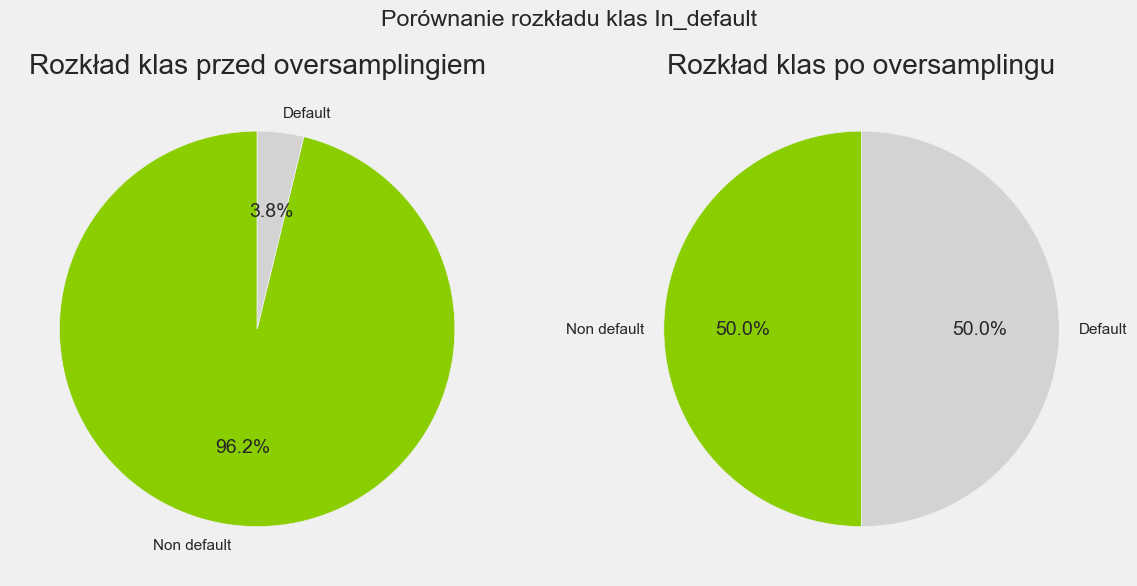

In [29]:
before_oversampling = y_train.value_counts()
after_oversampling = y_train_resampled.value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(
    before_oversampling,
    labels=['Non default', 'Default'],
    autopct='%1.1f%%',
    colors=['#8ACE00', 'lightgrey'],
    startangle=90
)
axes[0].set_title('Rozkład klas przed oversamplingiem')

axes[1].pie(
    after_oversampling,
    labels=['Non default', 'Default'],
    autopct='%1.1f%%',
    colors=['#8ACE00', 'lightgrey'],
    startangle=90
)
axes[1].set_title('Rozkład klas po oversamplingu')

fig.suptitle('Porównanie rozkładu klas In_default')
plt.tight_layout()
plt.show()

## 5.3 Wybór modelu

In [30]:
def evaluate_model(model, X, y, model_name="Model"):
    y_pred = model.predict(X)
    y_probs = model.predict_proba(X)[:, 1]
    
    results = {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1': f1_score(y, y_pred),
        'roc_auc': roc_auc_score(y, y_probs)
    }
    
    print(f"\nWyniki dla {model_name}:")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")
        
    return results

In [31]:
def plot_confusion_matrix(model, X, y, title="Confusion Matrix"):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False)
    plt.title(title)
    plt.ylabel('Rzeczywiste wartości')
    plt.xlabel('Przewidywane wartości')
    plt.tight_layout()
    plt.show()
    
    return y_pred

In [32]:
def plot_roc_curves(models_dict, X, y, title="ROC Curve"):
    plt.figure(figsize=(10, 8))
    
    for model_name, model in models_dict.items():
        if hasattr(model, "predict_proba"):
            y_probs = model.predict_proba(X)[:, 1]
            fpr, tpr, _ = roc_curve(y, y_probs)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [33]:
models_standard = {}
models_resampled = {}
val_results_standard = {}
val_results_resampled = {}


--- Regresja Logistyczna ---

Wyniki dla Regresja Logistyczna (bez oversamplingu):
accuracy: 0.9660
precision: 0.6538
recall: 0.2237
f1: 0.3333
roc_auc: 0.9220


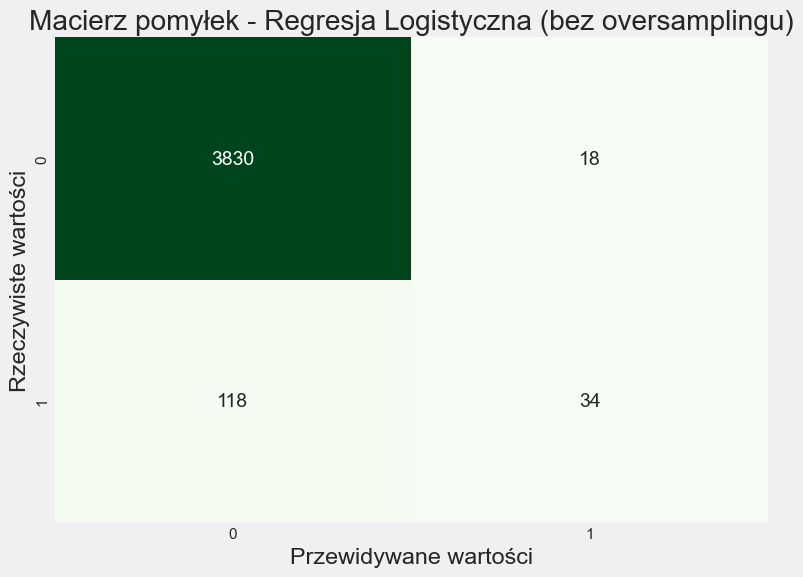


Wyniki dla Regresja Logistyczna (z oversamplingiem):
accuracy: 0.8468
precision: 0.1721
recall: 0.7961
f1: 0.2830
roc_auc: 0.8984


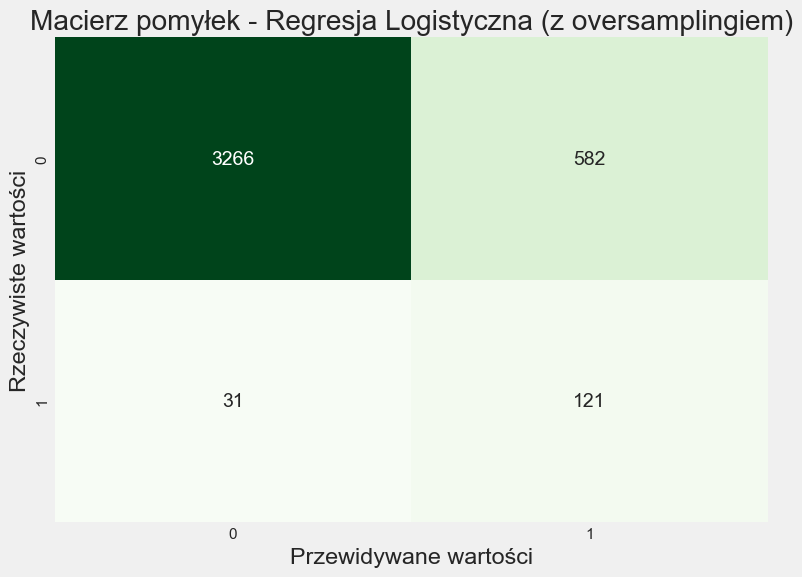

array([0, 0, 0, ..., 0, 0, 0])

In [34]:
print("\n--- Regresja Logistyczna ---")
# Bez oversamplingu
log_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
log_reg_pipeline.fit(X_train, y_train)
models_standard['Regresja Logistyczna'] = log_reg_pipeline
val_results_standard['Regresja Logistyczna'] = evaluate_model(log_reg_pipeline, X_val, y_val, model_name="Regresja Logistyczna (bez oversamplingu)")
plot_confusion_matrix(log_reg_pipeline, X_val, y_val, title="Macierz pomyłek - Regresja Logistyczna (bez oversamplingu)")

# Z oversamplingiem
log_reg_resampled_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
log_reg_resampled_pipeline.fit(X_train_resampled, y_train_resampled)
models_resampled['Regresja Logistyczna'] = log_reg_resampled_pipeline
val_results_resampled['Regresja Logistyczna'] = evaluate_model(log_reg_resampled_pipeline, X_val, y_val, model_name="Regresja Logistyczna (z oversamplingiem)")
plot_confusion_matrix(log_reg_resampled_pipeline, X_val, y_val, title="Macierz pomyłek - Regresja Logistyczna (z oversamplingiem)")



--- Random Forest ---

Wyniki dla Random Forest (bez oversamplingu):
accuracy: 0.9635
precision: 0.5441
recall: 0.2434
f1: 0.3364
roc_auc: 0.8882


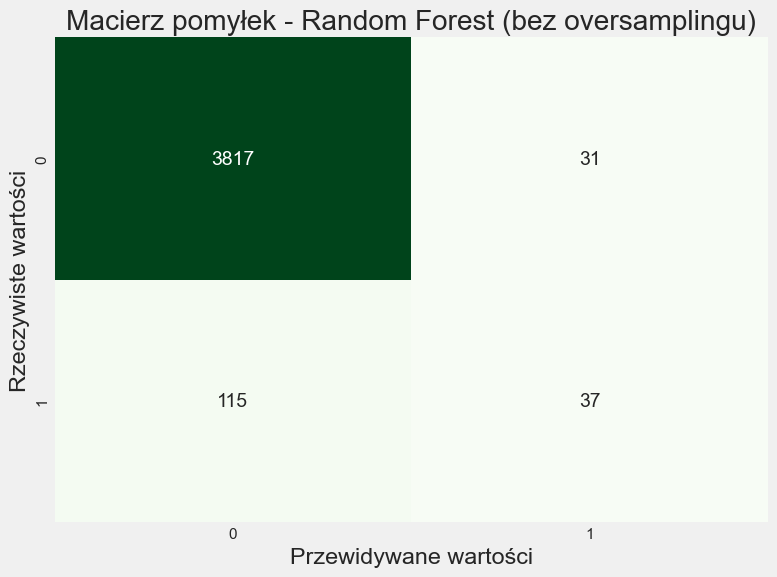


Wyniki dla Random Forest (z oversamplingiem):
accuracy: 0.9225
precision: 0.2367
recall: 0.4671
f1: 0.3142
roc_auc: 0.8781


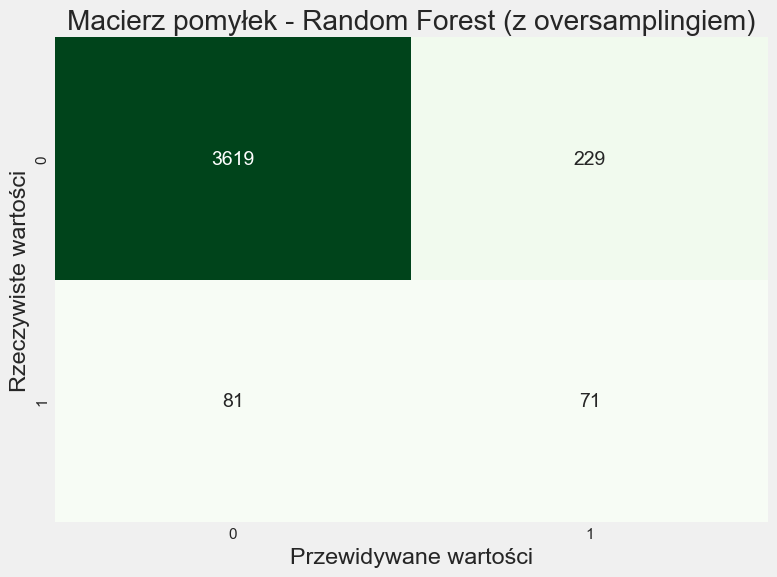

array([0, 0, 0, ..., 0, 0, 0])

In [35]:
print("\n--- Random Forest ---")
# Bez oversamplingu
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
models_standard['Random Forest'] = rf
val_results_standard['Random Forest'] = evaluate_model(rf, X_val, y_val, model_name="Random Forest (bez oversamplingu)")
plot_confusion_matrix(rf, X_val, y_val, title="Macierz pomyłek - Random Forest (bez oversamplingu)")

# Z oversamplingiem
rf_resampled = RandomForestClassifier(n_estimators=100, random_state=42)
rf_resampled.fit(X_train_resampled, y_train_resampled)
models_resampled['Random Forest'] = rf_resampled
val_results_resampled['Random Forest'] = evaluate_model(rf_resampled, X_val, y_val, model_name="Random Forest (z oversamplingiem)")
plot_confusion_matrix(rf_resampled, X_val, y_val, title="Macierz pomyłek - Random Forest (z oversamplingiem)")



--- XGBoost ---

Wyniki dla XGBoost (bez oversamplingu):
accuracy: 0.9635
precision: 0.5405
recall: 0.2632
f1: 0.3540
roc_auc: 0.8969


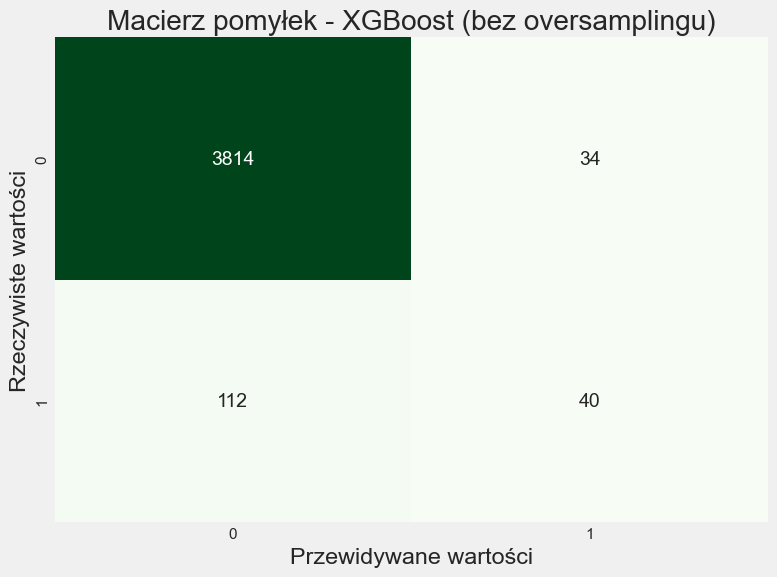


Wyniki dla XGBoost (z oversamplingiem):
accuracy: 0.9465
precision: 0.3278
recall: 0.3882
f1: 0.3554
roc_auc: 0.8689


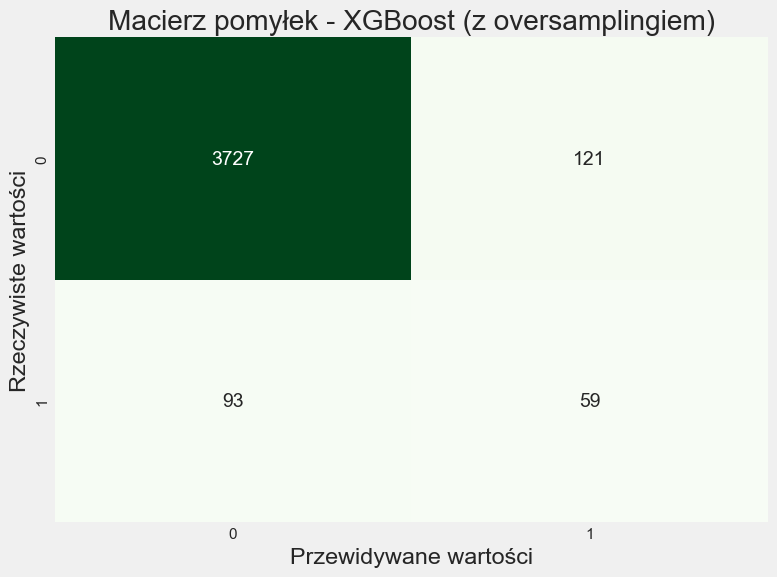

array([0, 0, 0, ..., 0, 0, 0])

In [36]:
print("\n--- XGBoost ---")
# Bez oversamplingu
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
models_standard['XGBoost'] = xgb_model
val_results_standard['XGBoost'] = evaluate_model(xgb_model, X_val, y_val, model_name="XGBoost (bez oversamplingu)")
plot_confusion_matrix(xgb_model, X_val, y_val, title="Macierz pomyłek - XGBoost (bez oversamplingu)")

# Z oversamplingiem
xgb_resampled = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_resampled.fit(X_train_resampled, y_train_resampled)
models_resampled['XGBoost'] = xgb_resampled
val_results_resampled['XGBoost'] = evaluate_model(xgb_resampled, X_val, y_val, model_name="XGBoost (z oversamplingiem)")
plot_confusion_matrix(xgb_resampled, X_val, y_val, title="Macierz pomyłek - XGBoost (z oversamplingiem)")


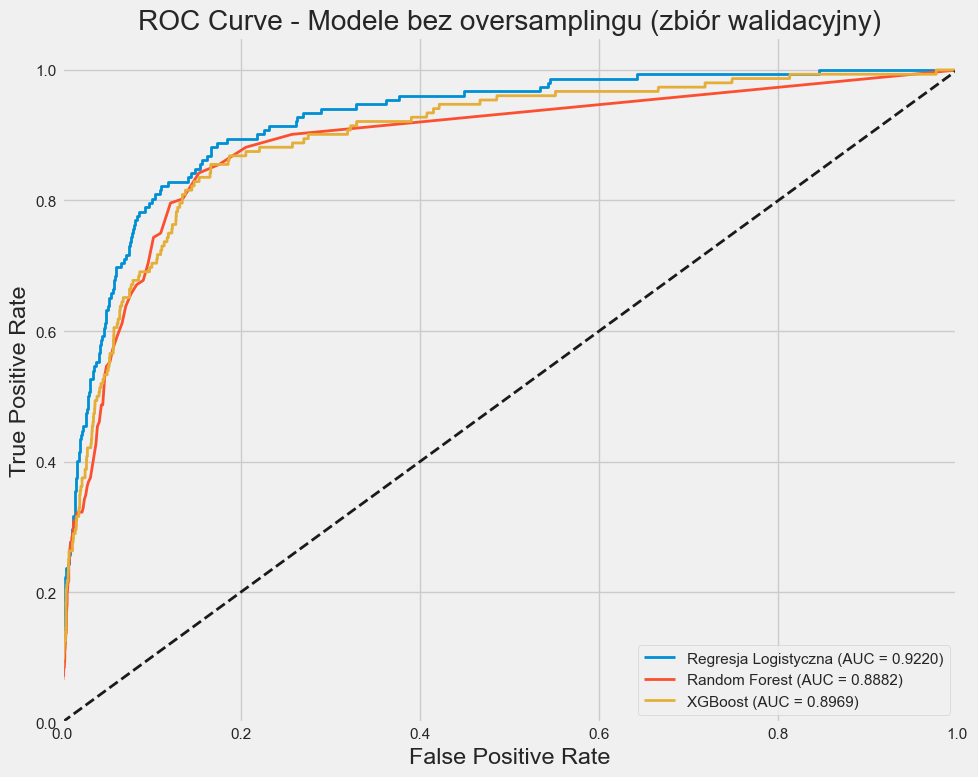

In [37]:
plot_roc_curves(models_standard, X_val, y_val, title="ROC Curve - Modele bez oversamplingu (zbiór walidacyjny)")

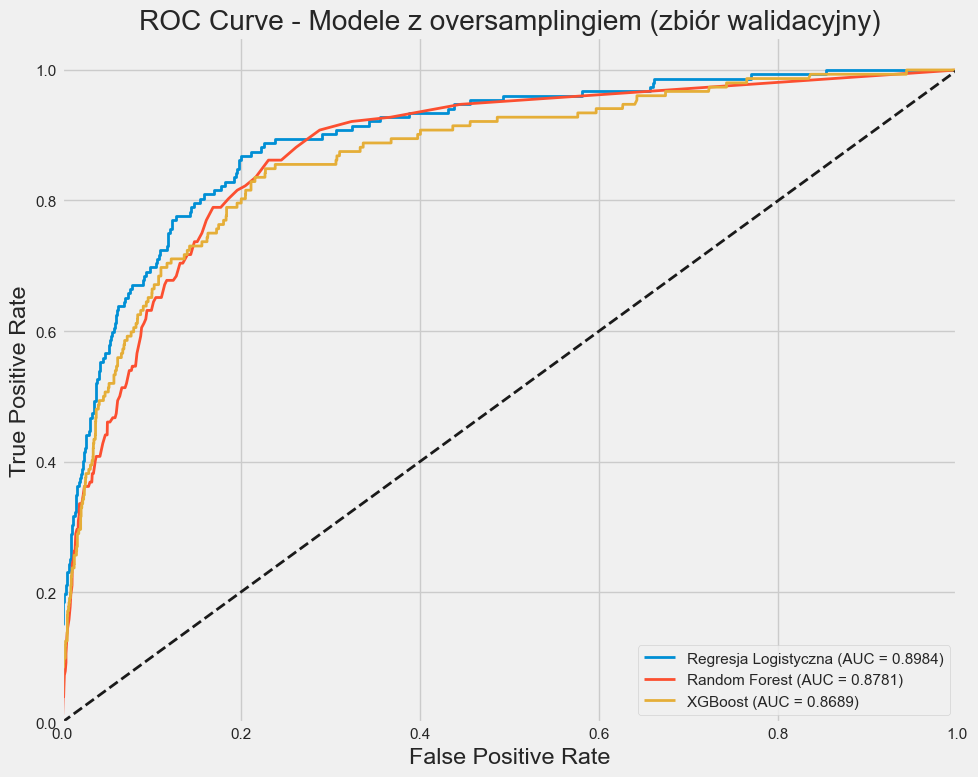

In [38]:
plot_roc_curves(models_resampled, X_val, y_val, title="ROC Curve - Modele z oversamplingiem (zbiór walidacyjny)")

In [39]:
results_df_standard = pd.DataFrame(val_results_standard).T[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]
results_df_resampled = pd.DataFrame(val_results_resampled).T[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]

print("\n--- Podsumowanie wyników na zbiorze walidacyjnym (bez oversamplingu) ---")
print(results_df_standard)

print("\n--- Podsumowanie wyników na zbiorze walidacyjnym (z oversamplingiem) ---")
print(results_df_resampled)



--- Podsumowanie wyników na zbiorze walidacyjnym (bez oversamplingu) ---
                      accuracy  precision  recall    f1  roc_auc
Regresja Logistyczna     0.966      0.654   0.224 0.333    0.922
Random Forest            0.964      0.544   0.243 0.336    0.888
XGBoost                  0.964      0.541   0.263 0.354    0.897

--- Podsumowanie wyników na zbiorze walidacyjnym (z oversamplingiem) ---
                      accuracy  precision  recall    f1  roc_auc
Regresja Logistyczna     0.847      0.172   0.796 0.283    0.898
Random Forest            0.922      0.237   0.467 0.314    0.878
XGBoost                  0.947      0.328   0.388 0.355    0.869


### Wyniki 📊
- **Bez oversamplingu**: Regresja Logistyczna osiąga najwyższą dokładność (96.6%) i AUC (0.922), ale ma niską czułość (22.4%). XGBoost ma najlepszy balans między metrykami z F1 = 0.354.
- **Z oversamplingiem**: XGBoost osiąga najwyższą dokładność (94.7%) i F1 (0.355), ale kosztem niższej czułości (38.8%) w porównaniu do Regresji Logistycznej (79.6%).


In [40]:
best_model_standard = results_df_standard['f1'].idxmax()
best_model_resampled = results_df_resampled['f1'].idxmax()

print(f"Najlepszy model bez oversamplingu: {best_model_standard} (F1: {results_df_standard.loc[best_model_standard, 'f1']:.4f})")
print(f"Najlepszy model z oversamplingiem: {best_model_resampled} (F1: {results_df_resampled.loc[best_model_resampled, 'f1']:.4f})")


Najlepszy model bez oversamplingu: XGBoost (F1: 0.3540)
Najlepszy model z oversamplingiem: XGBoost (F1: 0.3554)


In [41]:
if results_df_resampled.loc[best_model_resampled, 'f1'] > results_df_standard.loc[best_model_standard, 'f1']:
    final_best_model = f"{best_model_resampled} (z oversamplingiem)"
    final_metric = results_df_resampled.loc[best_model_resampled, 'f1']
else:
    final_best_model = f"{best_model_standard} (bez oversamplingu)"
    final_metric = results_df_standard.loc[best_model_standard, 'f1']

print(f"\n--- FINALNA REKOMENDACJA ---")
print(f"Najlepszy model do wdrożenia: {final_best_model}")
print(f"F1 Score: {final_metric:.4f}")



--- FINALNA REKOMENDACJA ---
Najlepszy model do wdrożenia: XGBoost (z oversamplingiem)
F1 Score: 0.3554


---
# 6. Wdrozenie 


Wyniki dla XGBoost (z oversamplingiem):
accuracy: 0.9477
precision: 0.3273
recall: 0.3553
f1: 0.3407
roc_auc: 0.8600


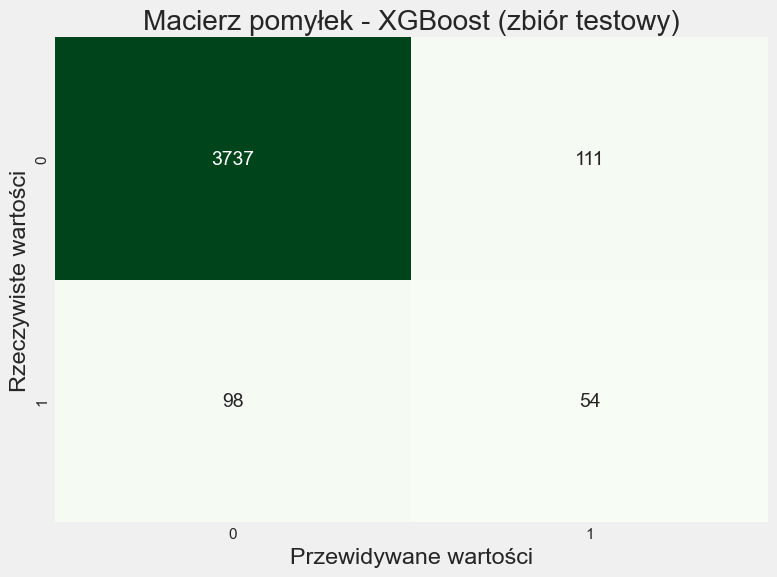

array([0, 0, 0, ..., 0, 0, 0])

In [42]:
best_model = models_resampled[best_model_resampled]
test_results = evaluate_model(best_model, X_test, y_test, model_name=f"{best_model_resampled} (z oversamplingiem)")

# Rysowanie macierzy pomyłek
plot_confusion_matrix(best_model, X_test, y_test, title=f"Macierz pomyłek - {best_model_resampled} (zbiór testowy)")

In [43]:
print("\n--- Porównanie wyników najlepszego modelu ---")
val_metrics = val_results_resampled[best_model_resampled]
test_metrics = test_results

for metric in val_metrics:
    print(f"{metric}: Walidacyjny = {val_metrics.get(metric):.4f}, Test = {test_metrics.get(metric):.4f}, " + 
          f"Różnica = {(test_metrics.get(metric) - val_metrics.get(metric)):.4f}")


--- Porównanie wyników najlepszego modelu ---
accuracy: Walidacyjny = 0.9465, Test = 0.9477, Różnica = 0.0012
precision: Walidacyjny = 0.3278, Test = 0.3273, Różnica = -0.0005
recall: Walidacyjny = 0.3882, Test = 0.3553, Różnica = -0.0329
f1: Walidacyjny = 0.3554, Test = 0.3407, Różnica = -0.0147
roc_auc: Walidacyjny = 0.8689, Test = 0.8600, Różnica = -0.0089


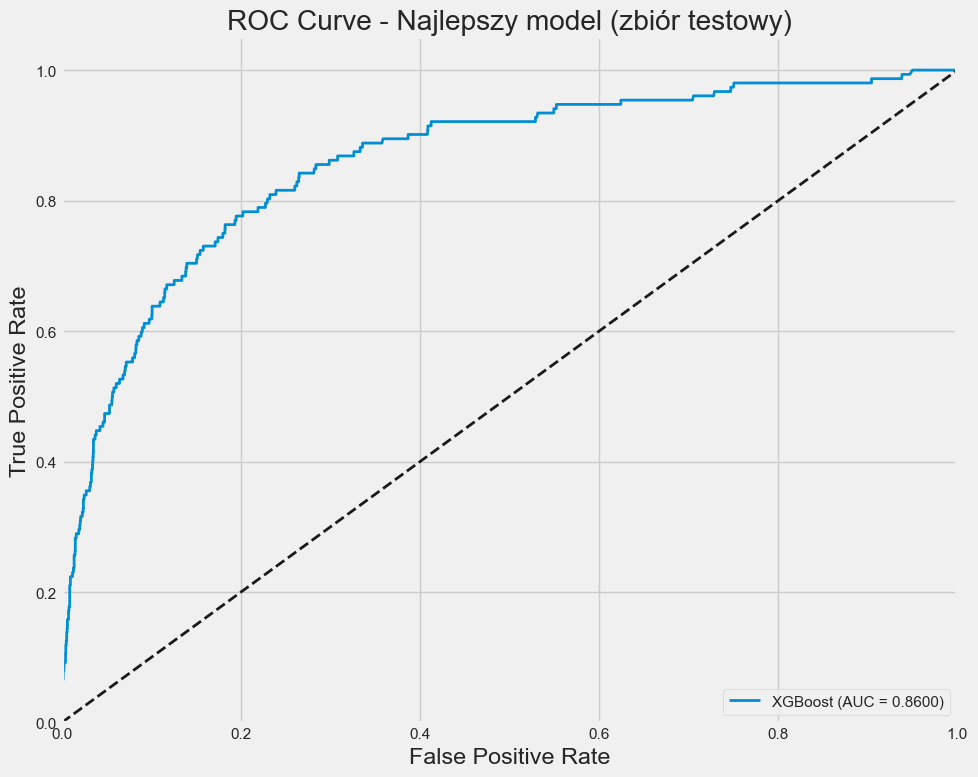

In [44]:
plot_roc_curves({best_model_resampled: best_model}, X_test, y_test, title="ROC Curve - Najlepszy model (zbiór testowy)")

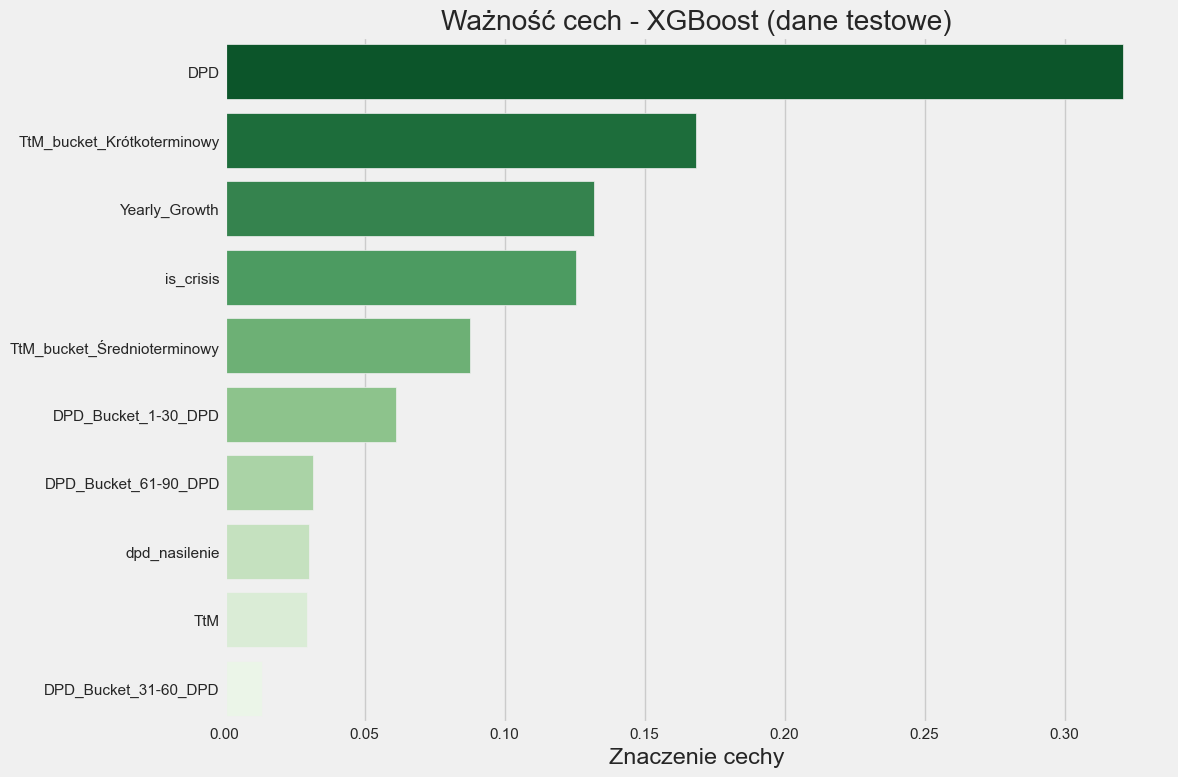

In [45]:
feature_importances = best_model.feature_importances_
feature_names = X_test.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette = sns.color_palette("Greens_r", n_colors=10))
plt.title('Ważność cech - XGBoost (dane testowe)')
plt.xlabel('Znaczenie cechy')
plt.ylabel('')
plt.tight_layout()
plt.show()

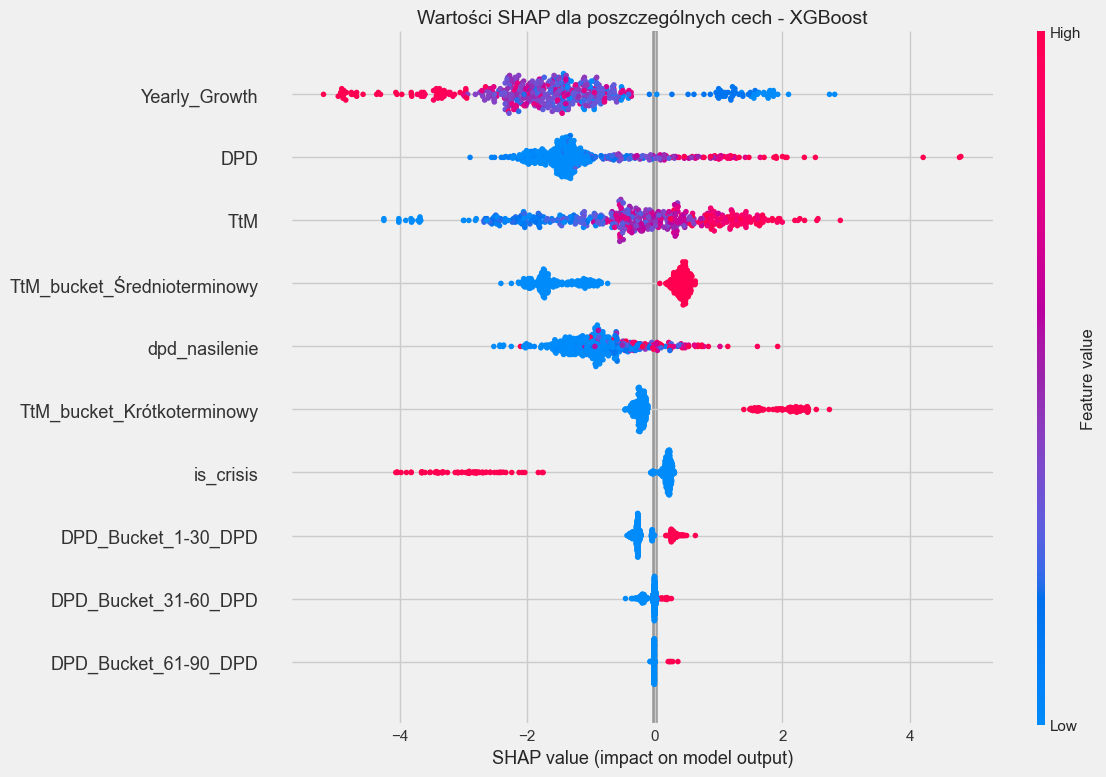

In [46]:
explainer = shap.TreeExplainer(xgb_resampled)

X_sample = X_train_resampled.iloc[:500]
shap_values = explainer.shap_values(X_sample)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, feature_names=list(X_train.columns),
                  show=False, plot_size=(12, 8))
plt.title('Wartości SHAP dla poszczególnych cech - XGBoost', fontsize=14)
plt.tight_layout()
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()